In [16]:
.libPaths("/home/groups/candes/Software/miniconda2/envs/ukb/lib/R/library")
suppressMessages(library(tidyverse))
suppressMessages(library(cowplot))

source("utils_manhattan.R")

scratch <- "/scratch/PI/candes/ukbiobank_tmp"
resolution <- "Radj100"

In [7]:
# Load phenotype table
pheno.file <- sprintf("%s/phenotypes/phenotypes_qc.tab", scratch)
Phenotypes <- read_tsv(pheno.file, col_types=cols())

In [9]:
# Load list of variants
Variants <- lapply(1:22, function(chr) {    # Load list of variants
    cat(sprintf("Loading list of variants on chromosome %d... ", chr))
    key.file <- sprintf("%s/knockoffs/%s_K50/ukb_gen_chr%d.key", scratch, resolution, chr)
    Variants.chr <- read_delim(key.file, delim=" ", col_types=cols())
    Variants.chr <- Variants.chr %>% mutate(CHR=Chr) %>% select(CHR, Variant, Position, Group, Knockoff)
    colnames(Variants.chr) <- c("CHR", "SNP", "BP", "Group", "Knockoff")
    # Load LD table
    ld.file <- sprintf("%s/knockoff_diagnostics/%s_K50/ukb_gen_chr%d.ld", scratch, resolution, chr)
    LD.chr <- read_table(ld.file, col_types=cols(), guess_max=21474836) %>%
        filter(BP_A==BP_B) %>%
        mutate(CHR=CHR_A, BP=BP_A) %>%
        select(CHR, BP, R2)
    # Combine list of variants with LD and MAF tables
    Variants.chr <- Variants.chr %>% left_join(LD.chr, by = c("CHR", "BP"))
    cat("done.\n")
    return(Variants.chr)
})
Variants <- do.call("rbind", Variants)

Loading list of variants on chromosome 1... done.
Loading list of variants on chromosome 2... done.
Loading list of variants on chromosome 3... done.
Loading list of variants on chromosome 4... done.
Loading list of variants on chromosome 5... done.
Loading list of variants on chromosome 6... done.
Loading list of variants on chromosome 7... done.
Loading list of variants on chromosome 8... done.
Loading list of variants on chromosome 9... done.
Loading list of variants on chromosome 10... done.
Loading list of variants on chromosome 11... done.
Loading list of variants on chromosome 12... done.
Loading list of variants on chromosome 13... done.
Loading list of variants on chromosome 14... done.
Loading list of variants on chromosome 15... done.
Loading list of variants on chromosome 16... done.
Loading list of variants on chromosome 17... done.
Loading list of variants on chromosome 18... done.
Loading list of variants on chromosome 19... done.
Loading list of variants on chromosome 2

## Manhattan plots

Dataset contains 14848 cases of diabetes and 335231 controls (case fraction: 4.43%).


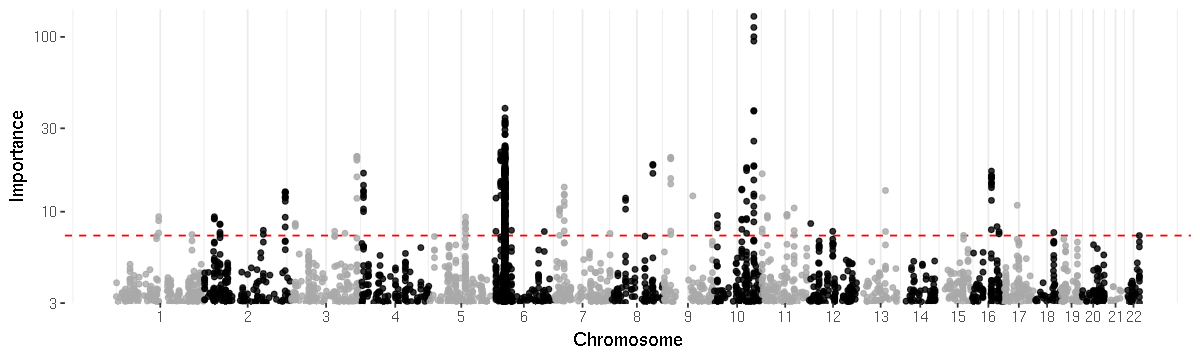

In [22]:
source("utils_manhattan.R")

# Specify phenotype
phenotype <- "diabetes"

case.controls <- table(Phenotypes[[phenotype]])
if(length(case.controls)==2) {
    cat(sprintf("Dataset contains %d cases of %s and %d controls (case fraction: %.2f%%).\n", 
        case.controls[2], phenotype, case.controls[1], 100*case.controls[2]/case.controls[1]))
}

# Load LMM p-values
lmm.file <- sprintf("%s/analysis/bolt/%s_stats.txt", scratch, phenotype)
LMM <- read_tsv(lmm.file, col_types=cols())
if("P_BOLT_LMM" %in% colnames(LMM)) {
    LMM <- LMM %>% mutate(P=P_BOLT_LMM)
} else {
    LMM <- LMM %>% mutate(P=P_BOLT_LMM_INF)
}

# Manhattan plot 
options(repr.plot.width=10, repr.plot.height=3)
p.man <- plot_manhattan(LMM)
p.man
summary.file <- sprintf("figures/manhattan_%s.png", phenotype)
ggsave(summary.file, p.man, width=10, height=6)

In [207]:
# Load knockoff statistics
resolution <- "Radj2"
out.file <- sprintf("%s/analysis/knockoffs/%s_%s_lasso.txt", scratch, phenotype, resolution)
Lasso <- read_delim(out.file, delim=" ", col_types=cols())

# Compute the knockoff statistics
W.stats <- function(Z, knockoff) {
    importance <- abs(Z)
    z  <- sum(importance[which(knockoff==FALSE)], na.rm=T)
    zk <- sum(importance[which(knockoff==TRUE)], na.rm=T)
    w <- z-zk
}

Stats <- Lasso %>% select("Resolution", "CHR", "Group", "SNP", "BP", "Importance") %>%
    filter(Importance!=0) %>% 
    left_join(Variants, by = c("CHR", "Group", "SNP", "BP")) %>%
    group_by(Resolution, CHR, Group) %>%
    summarize(W = W.stats(Importance,Knockoff),
              Lead=which.max(Importance), SNP.lead=SNP[Lead], BP.lead=BP[Lead],
              Size=n(), R2=max(R2)) %>%
    mutate(SNP.lead = gsub(".A", "", SNP.lead), SNP.lead = gsub(".B", "", SNP.lead)) %>%
    ungroup() %>%
    arrange(desc(abs(W))) %>%
    select(CHR, Group, SNP.lead, BP.lead, Size, W, R2, Resolution) %>%
    filter(W!=0)

In [190]:
Stats %>%
    mutate(SNP=SNP.lead, BP=BP.lead, P=exp(-W*W.scale)) %>%
    filter(P<=5e-8) %>% nrow

knockoff.filter <- function(Stats, fdr=0.1, offset=1) {
    W.thres <- knockoff.threshold(Stats$W, fdr=fdr, offset=offset)
    Selected <- Stats %>% filter(W >= W.thres)
    return(Selected)
}

R2.max <- 1
Stats %>% filter(is.na(R2)|R2<=R2.max) %>% knockoff.filter(fdr=0.1, offset=1) %>% nrow()

[1] 3654

[1] 472

## Custom Manhattan plot

In [208]:
source("utils_manhattan.R")

options(repr.plot.width=10, repr.plot.height=5)
p.manhattan <- plot_manhattan_knockoffs(LMM, Stats)
#p.manhattan

summary.file <- sprintf("figures/manhattan_%s.png", phenotype)
ggsave(summary.file, p.manhattan, width=10, height=6)